# Predicting faulty water pumps

# Data Cleaning & Feature Engineering & Preprocessing ¶

## Import Libraries
Import libraries necessary to for the data cleaning, feature engineering and modeling

In [1]:
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from IPython.display import display  # use of display() for DataFrames
from itertools import compress
import wp_utility as wp_util
import gis_map_viz as gis_map

# Import Preprocessing and ML libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE

%matplotlib inline

In [2]:
_debug = False

class Water_Asset_Data:
    def __init__(self, train_feature_file, train_label_file, test_feature_file, cat_cols, ord_cols, bool_cols, num_cols, label_col, id_col):
        '''create training and testing panda dataframes'''
        # Save data features by type and label
        print("Water_Asset_Data: __init__ ...")

        self.cat_cols = list(cat_cols)
        self.num_cols = list(num_cols)
        self.bool_cols = list(bool_cols)
        self.ord_cols = list(ord_cols)
        self.label_col = label_col
        self.id_col = id_col
        self.feature_cols = cat_cols + num_cols + bool_cols
        self.label_names = []

        self.saved_train_file_name = 'clean_wp_train_features_df_'
        self.saved_test_file_name = 'clean_wp_test_features_df_'
        self.saved_object_file_name = 'clean_wp_data_object_'

        # Approximate GPS bounderies of Tanzania (hardcoded)
        self.gps_bounderies_dict = {
            'lat_min': -12, 'lat_max': 0, 'lon_min': 30, 'lon_max': 40, 'height_min': 0}

        # Save our train and test data frames
        self.train_feature_df = self._create_train_feature_df(train_feature_file)
        self.label_df = self._create_label_df(train_label_file)
        self.test_feature_df = self._create_test_feature_df(test_feature_file)
        

    def _create_train_feature_df(self, train_feature_file, clean_features=True, shuffle_data=True):
        '''creates training feature dataframe and cleans it from missing values'''
        print("Water_Asset_Data: _create_train_feature_df ...")

        train_feature_df = self._load_data_file(train_feature_file)
        #train_df = self._merge_df(
        #    train_feature_df, train_target_df, self.id_col)
        if clean_features:
            train_feature_df = self._clean_data(train_feature_df)
        if shuffle_data:
            train_feature_df = self._shuffle_data(train_feature_df)
        return train_feature_df
    
    def _create_label_df(self, train_target_file):
        '''creates the label dataframe'''
        print("Water_Asset_Data: _create_label_df ...")       
        train_target_df = self._load_data_file(train_target_file)
        self.label_names = train_target_df[self.label_col].unique()     
        return train_target_df

    def _create_test_feature_df(self, test_feature_file, clean_features=True):
        '''creates the test dataframes and cleans it from missing values'''
        print("Water_Asset_Data: _create_test_feature_df ...")

        test_df = self._load_data_file(test_feature_file)
        if clean_features:
            self._clean_data(test_df)
        return test_df
    
    def _select_features(self, n_best_features = 20):
        '''Select n most important features based on a basic random forest model'''
        print("Water_Asset_Data: _select_features ...")
        
        target_df = self.train_feature_df[self.label_col]
        feature_df = self.train_feature_df.drop(
            [self.id_col, self.label_col], axis=1)
        
        # Simple split of the training set
        X_train, X_test, y_train, y_test = train_test_split(feature_df, target_df, shuffle=False)

        # Select best encoded features using RFE
        estimator = RandomForestClassifier(n_jobs = -1)
        selector = RFE(estimator, n_best_features, step=1)
        selector = selector.fit(X_train, y_train)

        # Drop least important features
        cols_to_drop = list(compress(list(feature_df.columns), ~(selector.get_support(indices=False))))     
        self.train_feature_df.drop(cols_to_drop, inplace = True, axis=1)
        self.test_feature_df.drop(cols_to_drop, inplace = True, axis=1)
    
    def _encode_features(self):
        '''Preprocess and encode features'''
     
        train_len = self.train_feature_df.shape[0]
        
        # Encode label feature
        print("Water_Asset_Data: _encode_features label {}".format(self.label_col))
        self.label_df[self.label_col] = pd.Categorical(self.label_df[self.label_col]) #.codes
        #encoded_train_feature_df[self.label_col] = self.train_feature_df[self.label_col]
       
        # concatenate train and test data frames
        merged_df = pd.concat([self.train_feature_df, self.test_feature_df], axis=0)
        
        # Encode boolean features
        print("Water_Asset_Data: _encode_features boolean {}".format(self.bool_cols))
        for col in self.bool_cols:
            merged_df[col] = merged_df[col] * 1

        #  numeric features
        print("Water_Asset_Data: _encode_features numeric {}".format(self.num_cols))
        merged_df[self.num_cols] = merged_df[self.num_cols].apply(pd.to_numeric)

        #  ordinal features
        print("Water_Asset_Data: _encode_features ordinal {}".format(self.ord_cols))
        merged_df[self.ord_cols] = merged_df[self.ord_cols].apply(pd.to_numeric)
        
        # One hot encode all other categorical features
        print("Water_Asset_Data: _encode_features categorical {}".format(self.cat_cols))
        encoded_cat_feature_df = pd.get_dummies(merged_df[self.cat_cols])
        merged_df.drop(self.cat_cols, axis=1, inplace = True)

        encoded_df = pd.concat([merged_df, encoded_cat_feature_df], axis=1)
        
        # Save encoded dfs
        self.train_feature_df = encoded_df.iloc[:train_len,:]
        self.train_feature_df = self._merge_df(train_feature_df = self.train_feature_df, train_label_df = self.label_df ,merge_on_feature= self.id_col)
        self.test_feature_df = encoded_df.iloc[train_len:,:]

        print("Water_Asset_Data: _encode_features train set shape {} , test set shape {}".format(
            self.train_feature_df.shape, self.test_feature_df.shape))

    def _engineer_features(self):
        '''Generate features for test and training dataframes'''
        print("Water_Asset_Data: _engineer_features ...")
        self.train_feature_df = self._engineer_age_feature(self.train_feature_df)
        self.test_feature_df = self._engineer_age_feature(self.test_feature_df)

    def _load_data_file(self, file_name, verbose=True):
        '''Load Pickle data file'''
        file_df = pd.read_pickle(file_name)
        if verbose:
            print("Water_Asset_Data: _load_data_file - pickle file {} loaded with shape {}".format(file_name, file_df.shape))
        return file_df

    def _save_dfs_to_file(self, clean_dir, verbose=False):
        '''Save dataframes to pickle data file'''
        print("Water_Asset_Data: _save_df_to_file to {}".format(clean_dir))

        file_time = datetime.datetime.now().strftime("%y%m%d%H")
        train_pkl_file = clean_dir + self.saved_train_file_name + file_time + '.pkl'
        test_pkl_file = clean_dir + self.saved_test_file_name + file_time + '.pkl'
        # Save cleaned panda dfs in repository
        try:
            self.train_feature_df.to_pickle(train_pkl_file)
            self.test_feature_df.to_pickle(test_pkl_file)
            if verbose:
                print("Water_Asset_Data: _save_df_to_file - {} and {} saved".format(train_pkl_file, test_pkl_file))
        except:
            print("Water_Asset_Data: _save_df_to_file {} failed".format(
                train_pkl_file, test_pkl_file))

    def _save_object_to_file(self, clean_dir, verbose=False):
        # Save the wp_data object in the clean-data repository
        print("Water_Asset_Data: _save_object_to_file to {}".format(clean_dir))

        file_time = datetime.datetime.now().strftime("%y%m%d%H")
        object_pkl_file = clean_dir + self.saved_object_file_name + file_time + '.pkl'
        # Save cleaned Water_Asset_Data object in repository
        with open(object_pkl_file, 'wb') as f:
            pickle.dump(wp_data, f, pickle.HIGHEST_PROTOCOL)

    def _merge_df(self, train_feature_df, train_label_df, merge_on_feature):
        '''Merge the training and label df on a specific key'''
        merged_df = pd.merge(
            left=train_feature_df, right=train_label_df, how='inner', on=merge_on_feature)
        return merged_df

    def _shuffle_data(self, df):
        '''Shuffle the observation in the dataframe'''
        return shuffle(df)

    def _clean_data(self, df):
        '''Impute missing values'''
        print("Water_Asset_Data: _clean_data ...")
        col_names = df.columns.tolist()

        # Transform ordinal values as object values
        for col in self.ord_cols:
            if col in col_names:
                df[col] = df[col].astype('str')

        # Normalise string categorical features to lower case
        for col in cat_cols:
            if col in col_names:
                df[col] = df[col].str.lower()

        # Transform all numerical values into numeric values
        df[self.num_cols] = df[self.num_cols].apply(pd.to_numeric)

        # Remove scheme_name feature (too many missing values)
        self._drop_features(df, ['scheme_name'])

        # replace invalid construction_years (0) with the median construction year
        valid_construction_year_df = df[df['construction_year'] > 0]
        median_construction_year_value = int(valid_construction_year_df['construction_year'].median())
        df['construction_year'].replace(0, median_construction_year_value, inplace=True)

        # replace likely invalid GPS values (out of Tanzania boundaries)
        self._clean_GPS_features(df, verbose=_debug)

        # replace funder feature missing values with its highest occurrence
        self._impute_null_with_highest_frequency_value(
            df, 'funder', verbose=_debug)
        # replace installer feature missing values with its highest occurrence
        self._impute_null_with_highest_frequency_value(
            df, 'installer', verbose=_debug)
        # replace public_meeting feature missing values by highest occurrence
        self._impute_null_with_highest_frequency_value(
            df, 'public_meeting', verbose=_debug)
        # replace scheme_management feature missing values by highest occurrence for each funder category
        self._impute_null_with_highest_frequency_value(
            df, 'scheme_management', 'funder', verbose=_debug)
        # replace permit feature missing values with highest occurrence for each installer category
        self._impute_null_with_highest_frequency_value(
            df, 'permit', 'installer', verbose=_debug)
        # replace subvillage feature missing values with highest occurrence for each region category
        self._impute_null_with_highest_frequency_value(
            df, 'subvillage', 'region', verbose=_debug)

        # Check if the training set has any missing values
        num_null_val = df.isnull().sum().sort_values(ascending=False)
        if _debug:
            display(num_null_val.head())
        assert (sum(num_null_val) == 0), "Water_Asset_Data: _clean_data - dataframe has missing values"

        print("Water_Asset_Data: _clean_data - data frame shape {}".format(df.shape))
        print("Water_Asset_Data: _clean_data - data frame feature list {} \n".format(df.columns.tolist()))
        return(df)

    def _engineer_age_feature(self, df):
        '''Generate new age features'''
        print("Water_Asset_Data: _engineer_age_feature \'pump_age\' and \'year_recorded\' ...")

        # Extract the of date_recorded feature and create a new feature: year_recorded
        df['year_recorded'] = df['date_recorded'].apply(self._extract_year)
        if 'year_recorded' not in self.num_cols:
            self.num_cols += ['year_recorded']

        # Compute the age of the pumps (in years) based on the construction_year and year of the obervation extracted
        df['pump_age'] = abs(df['year_recorded'] - df['construction_year'])
        if 'pump_age' not in self.num_cols:
            self.num_cols += ['pump_age']

        return(df)

    def _shrink_cat_features(self, cat_feature_list, threshold):
        '''Replace categorical feature values with number of occurrence below the treshhold provided '''
        print("_shrink_cat_features: _shrink_cat_features {}".format(cat_feature_list))
        for feature in cat_feature_list:
            self.train_feature_df[feature] = self._shrink_cat_feature(
                self.train_feature_df, feature, threshold)
            self.test_feature_df[feature] = self._shrink_cat_feature(
                self.test_feature_df, feature, threshold)

    def _shrink_cat_feature(self, df, cat_feature, threshold):
        '''Replace categorical feature values with number of occurrence below the treshhold provided '''
        print("Water_Asset_Data: shrink_cat_feature {}".format(cat_feature))
        s = (df[cat_feature].value_counts() <= threshold)
        list_to_replace = list(s[s == True].index)
        shrunk_cat_feature = df[cat_feature].apply(lambda x: (
            cat_feature + "_rare") if x in list_to_replace else x)
        return(shrunk_cat_feature)

    def _drop_features(self, df, feature_list):
        '''Remove feature list from data frames'''
        print("Water_Asset_Data: _drop_features ...")
        df.drop(feature_list, axis=1, inplace=True)
        for feature in feature_list:
            if feature in self.cat_cols:
                self.cat_cols.remove(feature)
            if feature in self.num_cols:
                self.num_cols.remove(feature)
            if feature in self.bool_cols:
                self.bool_cols.remove(feature)
            if feature in self.ord_cols:
                self.ord_cols.remove(feature)
        print("Water_Asset_Data: _drop_features - {} were dropped".format(feature_list))

    def _clean_GPS_features(self, df, verbose=False):
        '''Generate GPS features which seem out of Tanzania boundaries'''
        correct_gps_df = df[
            (df['latitude'] > self.gps_bounderies_dict['lat_min']) & (df['latitude'] < self.gps_bounderies_dict['lat_max']) &
            (df['longitude'] > self.gps_bounderies_dict['lon_min']) & (df['longitude'] < self.gps_bounderies_dict['lon_max']) &
            (df['gps_height'] > self.gps_bounderies_dict['height_min'])]

        # mean of gps coordinate types in each Tanzanian basin
        mean_correct_gps_df = correct_gps_df.groupby(
            ['basin'])['latitude', 'longitude', 'gps_height'].mean()

        # Replace likely invalid GPS values for each basin by basin GPS means
        basin_list = df['basin'].unique()
        for i in basin_list:
            correct_lon = mean_correct_gps_df.loc[i, 'longitude']
            if verbose:
                print("Updating invalid longitutes for basin {} by mean {}".format(
                    i, correct_lon))
            df[((df['longitude'] < self.gps_bounderies_dict['lon_min']) | (df['longitude'] > self.gps_bounderies_dict['lon_max'])) &
                (df['basin'] == i)]['longitude'] = correct_lon

            correct_lat = mean_correct_gps_df.loc[i, 'latitude']
            if verbose:
                print("Updating invalid latitudes for basin {} by mean {}".format(
                    i, correct_lat))
            df[((df['latitude'] < self.gps_bounderies_dict['lat_min']) | (df['latitude'] > self.gps_bounderies_dict['lat_max'])) &
                (df['basin'] == i)]['latitude'] = correct_lat

            correct_height = mean_correct_gps_df.loc[i, 'gps_height']
            if verbose:
                print("Updating invalid heights for basin {} by mean {}".format(
                    i, correct_height))
            df[(df['gps_height'] > self.gps_bounderies_dict['height_min']) &
               (df['basin'] == i)]['gps_height'] = correct_height

        return(df)

    def _extract_year(self, date):
        return (int(date.split('-')[0]))

    def _remove_list(self, orginal_list, list_to_be_removed):
        '''Remove a sublist from a list'''
        for i in list_to_be_removed:
            orginal_list.remove(i)

    def _impute_null_with_highest_frequency_value(self, df, impute_feature, frequency_feature=[], verbose=False):
        '''impute missing values based on the hightest occurrence of this feature in a seperate data slice'''
        impute_cat_set = df[impute_feature].nunique()

        if frequency_feature:
            feat_cat_list = df[frequency_feature].unique()
            for i in feat_cat_list:
                feat_cat = df[df[frequency_feature] == i][impute_feature]
                highest_feat_cat_occurrence = df[frequency_feature].value_counts(
                ).idxmax()
                if sum(feat_cat.notnull()):
                    highest_feat_cat_occurrence = feat_cat.value_counts().idxmax()
                if verbose:
                    print("Replacing {} feature null values: {} imputed by {}".format(
                        impute_feature, i, highest_feat_cat_occurrence))
                df[impute_feature].fillna(
                    value=highest_feat_cat_occurrence, inplace=True)
        else:
            highest_feat_cat_occurrence = df[impute_feature].value_counts().idxmax()
            if verbose:
                print("Replacing {} feature null values by {}".format(
                    impute_feature, highest_feat_cat_occurrence))
            df[impute_feature].fillna(value=highest_feat_cat_occurrence, inplace=True)

        # Sanity check: null values have been replaced
        assert impute_cat_set == df[impute_feature].nunique(), "Water_Asset_Data: - impute_null_with_highest_frequency_value: null values replaced assert failed"

## Load Water Pump Data Files, Create Data Frames and Clean The Data

#### Read in the data pump files stored in the directory raw-data into Pandas dataframes

In [3]:
!dir raw-data\*.pkl

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\raw-data

05/31/2018  12:20 PM         3,634,926 pump_test_features_df.pkl
05/31/2018  12:20 PM        14,615,910 pump_train_features_df.pkl
05/31/2018  12:20 PM           594,995 pump_train_label_df.pkl
06/18/2018  08:19 PM        32,059,977 wp_clean_data.pkl
               4 File(s)     50,905,808 bytes
               0 Dir(s)  1,927,181,242,368 bytes free


#### Define our different feature lists on which we will perform cleaning operation

In [4]:
# Define the data files extracted from the EDA phase
raw_data_dir = 'raw-data\\'
clean_data_dir = 'clean-data\\'

train_feature_file = raw_data_dir + 'pump_train_features_df.pkl'
train_label_file = raw_data_dir + 'pump_train_label_df.pkl'
test_feature_file = raw_data_dir + 'pump_test_features_df.pkl'


# Define the feature variables
cat_cols = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
            'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name',
            'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management',
            'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group',
            'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type',
            'waterpoint_type_group']

bool_cols = ['public_meeting', 'permit']

ord_cols = ['region_code', 'district_code']

num_cols = ['gps_height', 'population', 'construction_year',
            'amount_tsh', 'longitude', 'latitude']

label_col = 'status_group'

id_col = 'id'

## Create our cleaned testing and training data sets

### Inpute missing values
We've previously seen that the following features in the training set have NaN values that we will drop or impute: <br/> <br/>

<B> Nan/Null values count by feature: </B>

* scheme_name:              28166
* scheme_management:         3877
* installer:                 3655
* funder:                    3635
* public_meeting:            3334
* permit:                    3056
* subvillage:                 371

<br/> The Water_Asset_Data object will impute missing values and drop the scheme_name feature

In [5]:
# Create the data object to save the data frames
wp_data = Water_Asset_Data(train_feature_file, train_label_file, test_feature_file,
                           cat_cols, ord_cols, bool_cols, num_cols, label_col, id_col)

Water_Asset_Data: __init__ ...
Water_Asset_Data: _create_train_feature_df ...
Water_Asset_Data: _load_data_file - pickle file raw-data\pump_train_features_df.pkl loaded with shape (59400, 40)
Water_Asset_Data: _clean_data ...
Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['scheme_name'] were dropped


C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\ipykernel_launcher.py:313: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\ipykernel_launcher.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Water_Asset_Data: _clean_data - data frame shape (59400, 39)
Water_Asset_Data: _clean_data - data frame feature list ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'] 

Water_Asset_Data: _create_label_df ...
Water_Asset_Data: _load_data_file - pickle file raw-data\pump_train_label_df.pkl loaded with shape (59400, 2)
Water_Asset_Data: _create_test_feature_df ...
Water_Asset_Data: _load_data_file - pickle file raw-data\pump_test_features_df.pkl loaded with shape 

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\ipykernel_launcher.py:313: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\ipykernel_launcher.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Water_Asset_Data: _clean_data - data frame shape (14850, 39)
Water_Asset_Data: _clean_data - data frame feature list ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'] 



#### Check that no missing values have been left in both the test and training data set

In [6]:
display(wp_data.train_feature_df.isnull().sum().sort_values(ascending=False).head(5))
wp_data.train_feature_df.shape

waterpoint_type_group    0
num_private              0
ward                     0
lga                      0
district_code            0
dtype: int64

(59400, 39)

In [7]:
display(wp_data.train_feature_df.isnull().sum().sort_values(ascending=False).head(5))
wp_data.test_feature_df.head()

waterpoint_type_group    0
num_private              0
ward                     0
lga                      0
district_code            0
dtype: int64

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,dmdd,1996,dmdd,35.290799,-4.059696,dinamu secondary school,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,government of tanzania,1569,dwe,36.656709,-3.309214,kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,government of tanzania,1567,dwe,34.767863,-5.004344,puma secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,finn water,267,finn water,38.058046,-9.418672,kwa mzee pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,bruder,1260,bruder,35.006123,-10.950412,kwa mzee turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


#### Check that GPS information seems correct and print map of water points

We've previously noticed that some of these GPS value are invalid (e.g. negative altitude) as Tanzania has the following GPS bounderies:
* height > 0
* latitude: between 0S and -12S
* longitude: between 30E and 40E </br>

The GPS information that didn't fit into the country bounderies has now been cleaned-up <br/>
Tanzania is divided in water basin areas and this is likely relevant information for the prediction of the pump status.
We've replaced each GPS location that is out of the countries bounderies with the corresponding mean gps value of the basin it belongs to. <br/>

In [8]:
basin_list = wp_data.train_feature_df['basin'].unique()
wp_data.train_feature_df['basin'].value_counts()

lake victoria              10248
pangani                     8940
rufiji                      7976
internal                    7785
lake tanganyika             6432
wami / ruvu                 5987
lake nyasa                  5085
ruvuma / southern coast     4493
lake rukwa                  2454
Name: basin, dtype: int64

Now let's visually spot check that the gps features clean-up performed worked out properly

In [9]:
# feature names to be mapped
gps_map_features = ['latitude', 'longitude']

# create a map object
wp_map = gis_map.GIS_Map_Viz(latitude_feature_name = gps_map_features[0], longitude_feature_name = gps_map_features[1],
                             gps_bounderies_dict = wp_data.gps_bounderies_dict)

GIS_Map_Viz: __init__ ... v2


GIS_Map_Viz: _display_gps_map ...


C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


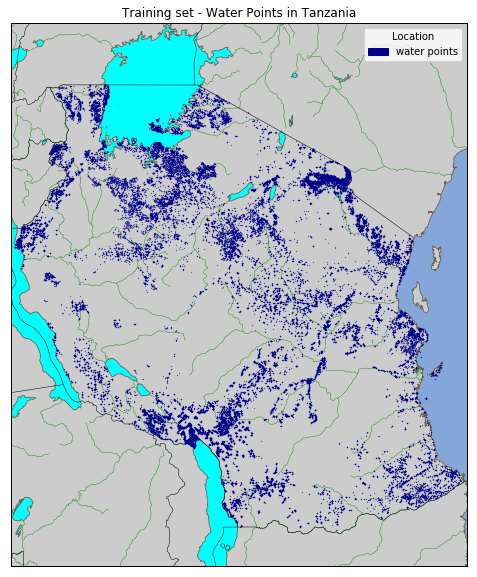

GIS_Map_Viz: _display_gps_map ...


C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


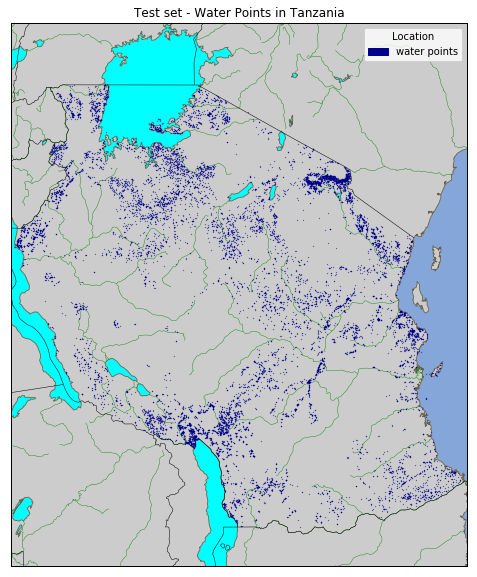

In [10]:
# Display the training and test maps with water points
labels = None
wp_map._display_gps_map(wp_data.train_feature_df, labels,
                        "Training set - Water Points in Tanzania")

wp_map._display_gps_map(wp_data.test_feature_df, labels,
                        "Test set - Water Points in Tanzania")

We observe that there are dense clusters of water points in the North and South East of the country while other areas are very water asset scarce

## Engineer Features

#### Compute the age of the pumps based on the construction_year
The age of the pump will likely be a better predictor of a pump failure than the year it was constructed. <br/>
We will compute the age of the pumps at the time the data set observations were recorded

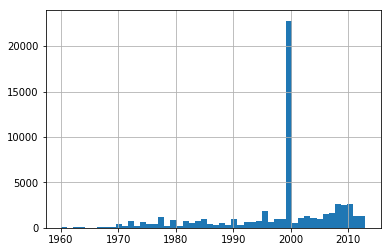

In [11]:
# Inspect construction_year feature
wp_data.train_feature_df['construction_year'].hist(bins=50)

In [12]:
# Compute the median contruction_year for pumps
wp_data._engineer_features()

Water_Asset_Data: _engineer_features ...
Water_Asset_Data: _engineer_age_feature 'pump_age' and 'year_recorded' ...
Water_Asset_Data: _engineer_age_feature 'pump_age' and 'year_recorded' ...


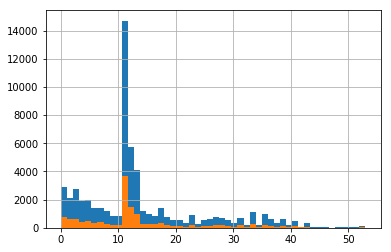

In [13]:
# Inspect construction_year feature
wp_data.train_feature_df['pump_age'].hist(bins=50)
wp_data.test_feature_df['pump_age'].hist(bins=50)

## Feature Selection

### Remove Irrelevant Features 
Some fatures likely have little correlation with the business outcome (pump failure prediction) and labels.<br/> 
In particular, we will drop the following features:
* date_recorded & year_recorded - The date and the year the row was entered
* recorded_by - Group entering this row of data
* num_private - No definitions provided

In [14]:
# drop irrelevant features
irrelevant_feat_list = ['date_recorded', 'num_private', 'year_recorded', 'recorded_by']
init_train_shape = wp_data.train_feature_df.shape
init_test_shape = wp_data.test_feature_df.shape

wp_data._drop_features(wp_data.train_feature_df, irrelevant_feat_list)
print ("Train set shape: {} to {} ".format(
    init_train_shape, wp_data.train_feature_df.shape))

wp_data._drop_features(wp_data.test_feature_df, irrelevant_feat_list)
print ("Test set shape: {} to {} ".format(
    init_test_shape, wp_data.test_feature_df.shape))

Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['date_recorded', 'num_private', 'year_recorded', 'recorded_by'] were dropped
Train set shape: (59400, 41) to (59400, 37) 
Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['date_recorded', 'num_private', 'year_recorded', 'recorded_by'] were dropped
Test set shape: (14850, 41) to (14850, 37) 


### Remove categorical features which are highly correlated or with high cardinalities (too many levels)

We observe that there are many data features with geographic information about the water points and wells, and soem of these have many different levels :
- Tanzania is divided into thirty-one regions
- Each region is subdivided into districts
- Each districts are sub-divided into divisions and local wards 
- Wards are further subdivided into streets and into villages
- Villages may be further subdivided into hamlets

In [15]:
display(wp_data.train_feature_df[wp_data.cat_cols].nunique().sort_values(ascending=False))

wpt_name                 37399
subvillage               19287
ward                      2092
installer                 1935
funder                    1897
lga                        125
region                      21
extraction_type             18
extraction_type_group       13
scheme_management           12
management                  12
source                      10
basin                        9
water_quality                8
waterpoint_type              7
extraction_type_class        7
payment                      7
payment_type                 7
source_type                  7
quality_group                6
waterpoint_type_group        6
management_group             5
quantity                     5
quantity_group               5
source_class                 3
dtype: int64

#### Identify categorical variable which are highly correlated using a Cramers V statistic method

In [16]:
# wp_util.show_cat_correlation(wp_data.train_feature_df, wp_data.cat_cols)

We will drop the features highly correlated and therefore redundant:
* lga 
* extraction_type_group 
* extraction_type_class 
* management_group 
* payment_type
* quality_group
* quantity_group
* source_type
* source_class
* waterpoint_type_group

We will also drop the number of features having high cardinality features:
* wpt_name - Name of the waterpoint if there is one <br/>
* subvillage - Geographic location<br/>
* ward - Geographic location<br/>
* funder - Who funded the well <br/>
* installer - Organization that installed the well

In [17]:
high_correlation_feat_list = ['lga','extraction_type_group', 'extraction_type_class',
                              'management_group', 'payment_type', 'quality_group', 'quantity_group',     
                              'source_type', 'source_class', 'waterpoint_type_group']

high_cardinality_feat_list = ['wpt_name', 'subvillage', 'ward', 'installer', 'funder'] # 'installer', 'funder'

init_train_shape = wp_data.train_feature_df.shape
init_test_shape = wp_data.test_feature_df.shape

wp_data._drop_features(wp_data.train_feature_df,
                       high_cardinality_feat_list+high_correlation_feat_list)
print ("Train set shape: {} to {} ".format(
    init_train_shape, wp_data.train_feature_df.shape))

wp_data._drop_features(wp_data.test_feature_df,
                       high_cardinality_feat_list+high_correlation_feat_list)
print ("Test set shape: {} to {} ".format(
    init_test_shape, wp_data.test_feature_df.shape))

Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['wpt_name', 'subvillage', 'ward', 'installer', 'funder', 'lga', 'extraction_type_group', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group'] were dropped
Train set shape: (59400, 37) to (59400, 22) 
Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['wpt_name', 'subvillage', 'ward', 'installer', 'funder', 'lga', 'extraction_type_group', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group'] were dropped
Test set shape: (14850, 37) to (14850, 22) 


#### Shrink the number of categories in the remaining high cardinality categorical features
* funder
* installer

In [18]:
#feature_list_to_shrink = ['funder', 'installer']

#wp_data._shrink_cat_features(feature_list_to_shrink, 10)

#### Let's look at the reduced set of features we will use to model the pump outcomes

In [19]:
display(wp_data.train_feature_df[wp_data.cat_cols].nunique().sort_values(ascending=False))

region               21
extraction_type      18
management           12
scheme_management    12
source               10
basin                 9
water_quality         8
waterpoint_type       7
payment               7
quantity              5
dtype: int64

In [20]:
wp_data.train_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 30397 to 37524
Data columns (total 22 columns):
id                   59400 non-null int64
amount_tsh           59400 non-null float64
gps_height           59400 non-null int64
longitude            59400 non-null float64
latitude             59400 non-null float64
basin                59400 non-null object
region               59400 non-null object
region_code          59400 non-null object
district_code        59400 non-null object
population           59400 non-null int64
public_meeting       59400 non-null bool
scheme_management    59400 non-null object
permit               59400 non-null bool
construction_year    59400 non-null int64
extraction_type      59400 non-null object
management           59400 non-null object
payment              59400 non-null object
water_quality        59400 non-null object
quantity             59400 non-null object
source               59400 non-null object
waterpoint_type      59400 non-n

## One Hot Encode categorical Features

In [21]:
wp_data._encode_features()

Water_Asset_Data: _encode_features label status_group
Water_Asset_Data: _encode_features boolean ['public_meeting', 'permit']
Water_Asset_Data: _encode_features numeric ['gps_height', 'population', 'construction_year', 'amount_tsh', 'longitude', 'latitude', 'pump_age']
Water_Asset_Data: _encode_features ordinal ['region_code', 'district_code']
Water_Asset_Data: _encode_features categorical ['basin', 'region', 'scheme_management', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']
Water_Asset_Data: _encode_features train set shape (59400, 122) , test set shape (14850, 121)


In [22]:
#wp_data._select_features(n_best_features = 100)

Shape of the one hot encoded features

In [23]:
wp_data.train_feature_df.shape

(59400, 122)

Check the labels

In [24]:
wp_data.train_feature_df[wp_data.label_col].unique()

[non functional, functional, functional needs repair]
Categories (3, object): [non functional, functional, functional needs repair]

#### Visualize the training set labels

GIS_Map_Viz: _display_gps_map ...


C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


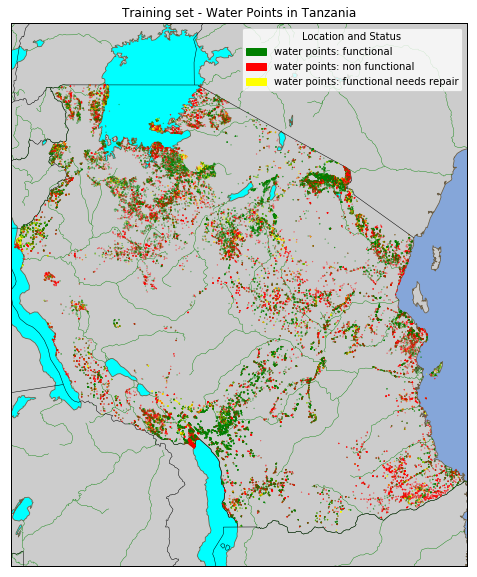

In [25]:
#Display the training maps with color coded water point status 
wp_map._display_gps_map(wp_data.train_feature_df, wp_data.train_feature_df[wp_data.label_col],
                        "Training set - Water Points in Tanzania")

## Save cleaned preprocessed data sets and data object

In [38]:
wp_data._save_dfs_to_file(clean_data_dir)
wp_data._save_object_to_file(clean_data_dir)

Water_Asset_Data: _save_df_to_file to clean-data\
Water_Asset_Data: _save_object_to_file to clean-data\


In [50]:
!dir clean-data

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\clean-data

07/28/2018  04:20 PM    <DIR>          .
07/28/2018  04:20 PM    <DIR>          ..
06/28/2018  10:44 AM               584 .floyddata
07/28/2018  04:20 PM        15,825,599 clean_wp_data_object.pkl
07/28/2018  03:05 PM        15,823,293 clean_wp_data_object_18072815.pkl
07/28/2018  02:23 PM         3,048,453 clean_wp_test_features_df_18072814.pkl
07/28/2018  03:05 PM         3,048,453 clean_wp_test_features_df_18072815.pkl
07/28/2018  02:23 PM        12,241,432 clean_wp_train_features_df_18072814.pkl
07/28/2018  03:05 PM        12,241,432 clean_wp_train_features_df_18072815.pkl
               7 File(s)     62,229,246 bytes
               2 Dir(s)  1,927,182,999,552 bytes free
